<a href="https://colab.research.google.com/github/1900690/kyouyu/blob/main/VGG16_and_gradcam/vgg16_transfer_learning_2.9_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VGG16を転移学習

参考サイト　http://bfin.sakura.ne.jp/?p=1159

##データと必要な環境を準備する
データのディレクトリ構造については、[githubのリポジトリ](https://github.com/suikan4github/dn_data)と、[Kerasのマニュアル](https://keras.io/ja/preprocessing/image/#flow_from_directory)を参照。

なお、クラスの文字列ラベルについては、ディレクトリ名から抽出している。

###データの準備

※独自のデータ行う場合はtrain、valid、testでフォルダを作る。それぞれのフォルダの中に分ける項目ごとのサブディレクトリが必要

※アップロードする場合は圧縮が必要、アップロードしてからファイル名とフォルダ内の整理を行う


※ランタイムをGPUに変更

ランタイムタブ＞ランタイムのタイプを変更ハードウェアアクセラレータをGPUに

####Google ドライブからデータを準備する場合

In [ ]:
#グーグルドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content
#--rの後ろの名前のフォルダをコピーして圧縮しzipの後ろの名前に変える
!cd "/content/drive/MyDrive/" && zip -q "バラ画像.zip" -r "バラ画像"

#ドライブからzipファイルをcontentに移動
!mv /content/drive/MyDrive/バラ画像.zip '/content/'

/content


In [ ]:
#zipファイルを解凍
!cd "/content/" && unzip -q バラ画像.zip
#zipファイルを消去
!cd "/content/" && rm バラ画像.zip

In [ ]:
##ローカルからデータを準備する場合
#from google.colab import files
#uploaded = files.upload()

##データを解凍する場合
#!unzip -q rose-mite_or_not-single-classification.v1i.folder.zip

###モジュールのインポート

In [ ]:
import os
import numpy as np
import sys
from PIL import Image

#グラフを日本語で表示するためにjapanize-matplotlibをインポート
!pip install japanize-matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib 

import datetime

#Jupyterでインライン表示するための宣言
%matplotlib inline 

     |████████████████████████████████| 4.1 MB 8.2 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=2a5e51f1b80e2e778685b39251cd5073acda4a09f07afffdbcac7402d2f35e11
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


###パラメーターの初期化
各種パラーメターをここで初期化する。

各種のイメージ分類に使う場合にはそれぞれのデータが格納されている場所をtrain_data_dir とvalidation_data_dirで指定する。それぞれにはクラス毎に画像データを分けたサブディレクトリをおく。サブディレクトリ名はクラス名になる。学習用とトレーニング用でディレクトリ構造をそろえておくこと。

VGG16に与える引数の詳細は[KerasのVGG16マニュアル](https://keras.io/ja/applications/#vgg16)を参照。

学習の速さや過学習と言った問題に取り組むにはnb_train_step_per_epoch やnb_epochを操作する。

In [ ]:
# 学習（訓練）に使うイメージと、学習結果の検証に使うイメージのディレクトリを指定する。
# これらのディレクトリはクラスに対応するサブディレクトリを持ち、サブディレクトリがクラス名になる
# 当然だが、学習用ディレクトリと検証用ディレクトリは同じ名前のサブディレクトリを持たなければならない
# クラスサブディレクトリの中にイメージがおいてある。イメージのサイズは自由。

train_data_dir = 'train'
validation_data_dir = 'valid'

#学習単位であるバッチの大きさ
#注意：元画像の数がバッチサイズで割り切れる必要がある
nb_batch_size = 15

# 内部処理するイメージの大きさ。値は自由だがVGG16を使うので48以上の値にする。
# チャンネル数はRGB3色なので3だが、いずれにせよVGG16を使う以上ここは3固定
# 詳細はKerasのマニュアルを参照 https://keras.io/ja/applications/#vgg16

img_rows, img_cols = 224,224
channels = 3

# 学習に使うイメージの総数を単位として、1エポックでどれだけのイメージを使って学習するかを指定する。
# イメージにはランダムに変形が施されているため、この数を増やすと学習用イメージを増やすのと同じ効果がある

nb_train_step_per_epoch = 2

# エポックの数

nb_epoch = 10

###GPUのメモリ割り当てをオンデマンドにする
GPUのメモリ割り当てを柔軟にするための設定。[Python: Keras/TensorFlow で GPU のメモリを必要な分だけ確保する - CUBE SUGAR CONTAINER](https://blog.amedama.jp/entry/2017/06/07/220723)を参考にした。

いろいろ調査してみた結果としては、性能に与えるインパクトは無視しうる模様。どの程度必要かは不明だが、おまじない程度に。

In [ ]:
#tensorflowが新しいバージョンでは動かないので古いものを適用
!pip install h5py==2.10.0

%tensorflow_version 1.x
import tensorflow as tf
from keras.backend import tensorflow_backend

from tensorflow import keras
from tensorflow.keras import optimizers


# see https://blog.amedama.jp/entry/2017/06/07/220723
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

     |████████████████████████████████| 2.9 MB 8.0 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
TensorFlow 1.x selected.


Using TensorFlow backend.


###学習用のデータジェネレータを作る
train_datagenは個々の写真データにどのような処理を施すかを指示するオブジェクトである。rescale引数は写真の内部のデータを[0,1.0]の区間に正規化するための指示である。Keras本にもこれを使うよう指示されているが、rescaleに関しては、[VGG16におけるKerasの前処理でmeanを引くかどうか - エイバースの中の人](http://blog.livedoor.jp/abars/archives/52428734.html)に、考察があり、それを参考にしてrescaleは行わないことにした。

shear_rangeやholizontal_flipは、画像毎にランダムに施される変形の指定である。こうした変形はnb_steps_per_epochが1の時には特に意味を持たないが、1よりも大きな場合には水増し(data augumentation)として機能するため、元データを増やした場合と同等の効果が期待される。

train_generatorは属性としてclass_indicesを持っており、そのなかにはテキストによるクラス名と対応するクラスインデックスがpythonの辞書データとして格納されている。

ただし、このことはKeras 2.0の[ドキュメント](https://keras.io/preprocessing/image/#flow_from_directory)には明確には書かれていない(2018/Jul)。以下のブログを参考にした。
[A thing you should know about Keras if you plan to train a deep learning model on a large dataset](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2)

class_indicesの長さから、クラスの数nb_classesを知ることができる。

なお、nb_classesは、あとでパーセプトロンを作るときの出力数の指定するときに必要になる。




In [ ]:
#ディレクトリを移動
%cd /content/

# VGG16を使うための画像前処理を適用する
train_datagen =  keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=nb_batch_size,
    shuffle=False)

# クラスの数
nb_classes = len(train_generator.class_indices)

/content
Found 45 images belonging to 2 classes.


###バリデーション用のデータジェネレータを作る
学習用のジェネレータと同じ手順で抽出するが、データに変形を施していない。検証データを水増ししても意味が無いと思われるからである。水増しを行いたい場合は[ImageDataGenerator](https://keras.io/ja/preprocessing/image/#imagedatagenerator)に変形用のパラメータを与え、nb_val_step_per_epochに1より大きな値を与える。


また、classの数は当然ながら学習用と同じである。


In [ ]:
#ディレクトリを移動
%cd /content/

test_datagen =  keras.preprocessing.image.ImageDataGenerator(
    )

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=nb_batch_size,
    shuffle=False)


/content
Found 15 images belonging to 2 classes.


##①新しく転移学習を行う場合
VGG16の全結合層を再訓練して新しいデータを学習させる。

パーセプトロン部(全結合層)を捨てているのは、出力のクラス数が元のVGG16と異なるからである。


###VGG16を元にネットワークを作成

In [ ]:
# VGG16モデルと学習済み重みをロード
# パーセプトロン部(Fully-connected層)はいらないのでinclude_top=False）
input_tensor = keras.layers.Input(shape=(img_rows, img_cols, 3))
model_feature = keras.applications.vgg16.VGG16(
                  include_top=False, 
                  weights='imagenet', 
                  input_tensor=input_tensor)
# model_feature.summary()

# 最後の畳み込み層を除く全ての畳み込み層をフリーズする
#for layer in model_feature.layers[:15]:
#    layer.trainable = False

# 転移学習をするときには、畳込み層を全てフリーズする
for layer in model_feature.layers:
    layer.trainable = False

# パーセプトロン部の作成
model_perceptron = keras.models.Sequential()
model_perceptron.add(keras.layers.Flatten(input_shape=model_feature.output_shape[1:]))
model_perceptron.add(keras.layers.Dense(256, activation='relu'))
model_perceptron.add(keras.layers.Dropout(0.5))
model_perceptron.add(keras.layers.Dense(
                      nb_classes, 
                      activation='softmax'))


# VGG16とパーセプトロンを接続する
model = keras.models.Model(inputs=model_feature.input, outputs=model_perceptron(model_feature.output))

# ネットワークを作ったら必ずコンパイルする
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=['accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step


###ネットワークに学習をさせる

fit_generatorはtrain_generatorからクラスの数や学習サンプルに対応する教師データを取得している。

In [ ]:
train_result = model.fit_generator(
      train_generator,
      steps_per_epoch = nb_train_step_per_epoch * len(train_generator),
      epochs = nb_epoch,
      validation_data = validation_generator,
      verbose=1)

now = datetime.datetime.now()
current_time = now.strftime("%d_%M")

model.save_weights("weight_fine_tuning_"+str(nb_classes)+"classes_"+current_time+".hdf5")

Epoch 1/10
6/6 [==============================] - 7s 1s/step - loss: 12.2599 - acc: 0.4556 - val_loss: 6.7157 - val_acc: 0.3333
Epoch 2/10
6/6 [==============================] - 1s 210ms/step - loss: 11.0885 - acc: 0.4333 - val_loss: 3.7464 - val_acc: 0.4667
Epoch 3/10
6/6 [==============================] - 1s 221ms/step - loss: 8.1067 - acc: 0.6111 - val_loss: 5.3086 - val_acc: 0.4667
Epoch 4/10
6/6 [==============================] - 1s 230ms/step - loss: 6.7189 - acc: 0.5778 - val_loss: 4.0812 - val_acc: 0.4667
Epoch 5/10
6/6 [==============================] - 1s 232ms/step - loss: 4.4607 - acc: 0.7000 - val_loss: 2.5910 - val_acc: 0.3333
Epoch 6/10
6/6 [==============================] - 1s 219ms/step - loss: 3.0087 - acc: 0.7556 - val_loss: 2.9846 - val_acc: 0.7333
Epoch 7/10
6/6 [==============================] - 1s 230ms/step - loss: 5.3434 - acc: 0.5889 - val_loss: 2.4892 - val_acc: 0.5333
Epoch 8/10
6/6 [==============================] - 1s 218ms/step - loss: 4.5864 - acc: 0.744

###学習の推移を描画する
学習結果がエポック毎にどうかわっていくかを描画する。

学習履歴はオブジェクトとしてfit()関数が返すので辞書機能を使って目的のデータ列を取り出している。例えば、train_result.hisotory["acc"]は精度の推移を示リスト。

描画は[Matplotlib](https://matplotlib.org/)の機能を使っている。以下のプログラムのfig変数は[matplotlib.figure.Figure](https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure)型。axes変数は[matplotlib.axes.Axes](https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes)型。

****************** 学習結果 ******************
画像サイズ                 :  224 * 224
クラスの数                 :  2
学習画像数                 :  60
バッチの大きさ             :  15
エポック内の学習ステップ数 :  2
エポック数                 :  10
最大正答率                 :  80.0 %


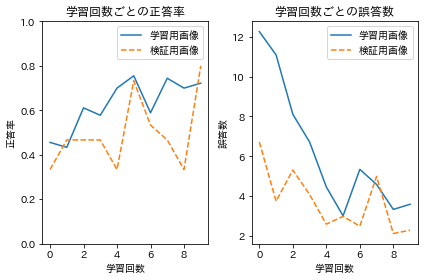

In [ ]:
print( "****************** 学習結果 ******************")
print( "画像サイズ                 : ", img_rows,"*",img_cols)#Input size
print( "クラスの数                 : ", nb_classes)#Classes
print( "学習画像数                 : ", train_generator.classes.shape[0]+validation_generator.classes.shape[0])#Samples for training
print( "バッチの大きさ             : ", nb_batch_size)#Batch size
print( "エポック内の学習ステップ数 : ", nb_train_step_per_epoch)#Training steps in an epoch
print( "エポック数                 : ", nb_epoch)#Epochs
seitouritu=round(max(train_result.history["val_acc"]),3)
print( "最大正答率                 : ", round(seitouritu*100,1),"%")

# １行２列のプロット画面を用意する
# figが画面。axesは画面の中のグラフのリスト
fig, axes = plt.subplots(1,2)

# 左側図形にエポック毎の精度の推移を描画する
axes[0].set_title("学習回数ごとの正答率")#Accuracy vs Epoch
axes[0].plot(train_result.history["acc"], label="学習用画像")#Training
axes[0].plot(train_result.history["val_acc"], label="検証用画像",linestyle="dashed")#Validation
axes[0].set_ylim(0,1)
axes[0].set_xlabel("学習回数")#Epoch
axes[0].set_ylabel("正答率")#Accuracy
axes[0].legend()

# 右側図形にエポック毎のロスの推移を描画する
axes[1].set_title("学習回数ごとの誤答数")#Loss vs Epoch
axes[1].plot(train_result.history["loss"], label="学習用画像")#Training
axes[1].plot(train_result.history["val_loss"], label="検証用画像",linestyle="dashed")#Validation
axes[1].set_xlabel("学習回数")#Epoch
axes[1].set_ylabel("誤答数")#Accuracy
axes[1].legend()

# subplotを綺麗に表示するためのまじない
fig.tight_layout()

##②学習済みの重みを用いてVGG16を元にネットワークを作る場合

In [ ]:
#ドライブから学習済み重みの入ったデータをコピー
!cp /content/drive/MyDrive/kiku_classification/weight_fine_tuning_2classes_21_09.hdf5 .

In [ ]:
#ディレクトリを移動
%cd /content/drive/MyDrive/kiku_classification/

#分類するクラスの数を記載
nb_classes =2

# VGG16モデルと学習済み重みをロード
# パーセプトロン部(Fully-connected層)はいらないのでinclude_top=False）
input_tensor = keras.layers.Input(shape=(img_rows, img_cols, 3))
model_feature = keras.applications.vgg16.VGG16(
                  include_top=False, 
                  weights='imagenet', 
                  input_tensor=input_tensor)
# model_feature.summary()

# 最後の畳み込み層を除く全ての畳み込み層をフリーズする
#for layer in model_feature.layers[:15]:
#    layer.trainable = False

# 転移学習をするときには、畳込み層を全てフリーズする
for layer in model_feature.layers:
    layer.trainable = False

# パーセプトロン部の作成
model_perceptron = keras.models.Sequential()
model_perceptron.add(keras.layers.Flatten(input_shape=model_feature.output_shape[1:]))
model_perceptron.add(keras.layers.Dense(256, activation='relu'))
model_perceptron.add(keras.layers.Dropout(0.5))
model_perceptron.add(keras.layers.Dense(
                      nb_classes, 
                      activation='softmax'))


# VGG16とパーセプトロンを接続する
model = keras.models.Model(inputs=model_feature.input, outputs=model_perceptron(model_feature.output))

# ネットワークを作ったら必ずコンパイルする
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=['accuracy'])
# 定義したモデルに重みを読み込ませる
from keras.models import load_model

#学習済みの重みのパスを記述
model.load_weights('weight_fine_tuning_2classes_21_09.hdf5')

model_feature.summary()

/content/drive/MyDrive/kiku_classification
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
bloc

##学習結果を試験するための準備
自分で用意した画像を表示し、認識結果を人間が読める形で出力する。

##クラス辞書の逆引き化
train_generatorは属性としてclass_indicesを持っており、そのなかにはテキストによるクラス名と対応するクラスインデックスがpythonの辞書データとして格納されている。

ただし、このことはKeras 2.0の[ドキュメント](https://keras.io/preprocessing/image/#flow_from_directory)には明確には書かれていない(2018/Jul)。以下のブログを参考にした。
[A thing you should know about Keras if you plan to train a deep learning model on a large dataset](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2)


In [ ]:
# 表示用のクラス辞書は、flow_from_fileジェネレータのclass_indicesから取得できる。
# ただしこの辞書は文字列型クラス名がキーで、ラベルのインデックスが値である。
class_dict = train_generator.class_indices

# 必要なのはインデックスからクラス名を引く機能なので逆引き辞書を作る
inv_class_dict = {v:k for k, v in class_dict.items()}

##画像認識関数の宣言

In [ ]:
def predict_picture(img_path):
  # 画像を指定パスからロードする。
  # 同時にネットワークが受け付けることのできる形にリサイズする。
  img = keras.preprocessing.image.load_img(img_path, target_size=(img_cols, img_rows))

  # 画像numpy配列に変換し、さらに4次元テンソルへ変換
  x = keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  # VGG16用の前処理。中でごにょごにょしている。
  x = keras.applications.vgg16.preprocess_input(x)

 # 対象画像を表示
  plt.imshow(np.array(img))
  ax = plt.gca()
  ax.grid(color='w', linestyle='none')

  # クラスを予測
  # pred()は実は複数枚うけとって、複数の結果を返す。
  # 入力は1枚の画像を含む4次元テンソルなので、出力から[0]のみとりだす。
  pred = model.predict(x)[0]

  #クラスごとに確立を表示
  print(inv_class_dict[0],"である確率",round(pred[0]*100,2),"%")
  print(inv_class_dict[1],"である確率",round(pred[1]*100,2),"%")
 
  
  # 予測確率が高いトップ5を出力
  #top = 5
  #top_indices = pred.argsort()[-top:][::-1]
  #result = [(inv_class_dict[i],pred[i]) for i in top_indices]
  #print(result)
  #for x in result:
  #    print(x)

#認識テスト
※testフォルダの中に入っている画像を直接指定してテストする

mite である確率 99.95 %
mite-free である確率 0.05 %


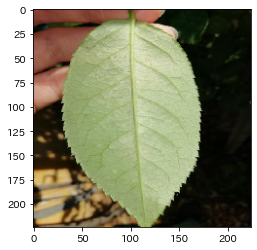

In [ ]:
predict_picture('/content/test/mite/IMG_20220310_111252_jpg.rf.0704b0a6edf13b9668831d67ca8f7567.jpg')

syuuhin である確率 0.0 %
yuuhin である確率 100.0 %


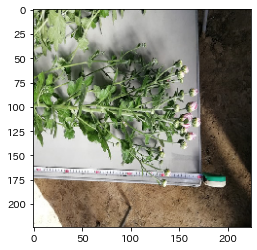

In [ ]:
predict_picture('/content/kiku_Classification_3/test/yuuhin/IMG_20211014_092553.jpg')

# GradCAM による VGG16 可視化

##事前準備

In [ ]:
#パッケージインストール
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import PIL
import cv2

データセット作成

In [ ]:
%cd /content
#ドライブからデータをコピー
#!cp /content/drive/MyDrive/kiku_classification/kiku_Classification_3.zip .

#zipファイルを解凍(ログを出さない)
#! unzip -q kiku_Classification_3.zip

/content


データセットを用意する。ここでは PlantVillage のデータの一部を使用する。分類対象のカテゴリ数は 2 である。

In [ ]:
#trainとvalidのデータパスを記載
train_data_dir = '/content/train'
valid_data_dir = '/content/valid'
#train_data_dir = 'drive/My Drive/datasets/plantvillage/train'
#valid_data_dir = 'drive/My Drive/datasets/plantvillage/valid'

data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
  'train': torchvision.datasets.ImageFolder(train_data_dir, transform=data_transforms['train']),
  'valid': torchvision.datasets.ImageFolder(valid_data_dir, transform=data_transforms['valid'])
}
#★バッチサイズはここで決定
#注意：元画像の数がバッチサイズで割り切れる必要がある
dataloaders = {
  'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=15, shuffle=True),
  'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=15)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'valid': len(image_datasets['valid'])
}

class_names = image_datasets['train'].classes

##学習

ImageNet で学習させた VGG16 を読み込み、そのアーキテクチャ全体のパラメーターを現在の学習データセットで再学習させる。

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_ft = torchvision.models.vgg16(pretrained=True)
num_ftrs = net_ft.classifier[6].in_features
net_ft.classifier[6] = torch.nn.Linear(num_ftrs, len(class_names))

net_ft = net_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#★学習回数の指定
num_epochs = 20
acc_history_ft = {'train': [], 'valid': []}

for epoch in range(num_epochs):

    for phase in ['train', 'valid']:
        if phase == 'train':
            net_ft.train()
        else:
            net_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = net_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        acc_history_ft[phase].append(epoch_acc)

In [ ]:
#重みの書き出し
%cd /content
from torchvision import models
model = models.vgg16()
torch.save(model.to('cpu').state_dict(), 'gradcam_0414.pth')

/content


In [ ]:
#重みのロード
%cd /content
#ドライブから重みをコピー
#!cp /content/drive/MyDrive/kiku_classification/gradcam_0308.pth .
#重みをVGG16に入れる
from torchvision import models
gradcam_model =  models.vgg16()
gradcam_model.load_state_dict(torch.load('gradcam_0414.pth'))

/content


<All keys matched successfully>

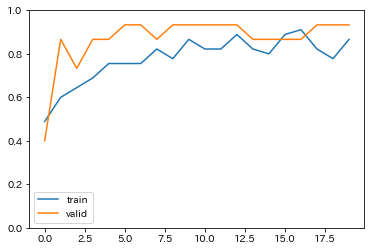

In [ ]:
#学習の様子
trainlist=list(acc_history_ft.values())[0]#dictからlistに変換
validlist=list(acc_history_ft.values())[1]
trainarray = np.empty(len(list(acc_history_ft.values())[0]))
validarray = np.empty(len(list(acc_history_ft.values())[0]))

for num in range(len(list(acc_history_ft.values())[0])):
  trainarray[num]=trainlist[num]#listからnumpy.ndarrayに変換
  validarray[num]=validlist[num]

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.transpose(trainarray), label='train')
ax.plot(np.transpose(validarray), label='valid')
ax.legend()
ax.set_ylim(0, 1)
fig.show()

##GradCAM画像表示

GradCAM による可視化を行う。アーキテクチャの最後の畳み込み層の計算結果を利用するので、最後の畳み込み層がどこにあるのかを確認する。

In [ ]:
print(net_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#ここをいじると取り出す層のデータを変えられる
layer_number=30

def gradcam(net, img_fpath):
    
    net.eval()
    net.zero_grad()

    img = PIL.Image.open(img_fpath).convert('RGB')
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = transforms(img)
    img = img.unsqueeze(0)

    # get features from the last convolutional layer
    x = net.features[:layer_number](img)
    features = x

    # hook for the gradients
    def __extract_grad(grad):
        global feature_grad
        feature_grad = grad
    features.register_hook(__extract_grad)

    # get the output from the whole VGG architecture
    x = net.features[layer_number:](x)
    x = net.avgpool(x)
    x = x.view(x.size(0), -1)
    output = net.classifier(x)
    pred = torch.argmax(output).item()
    print(pred)

    # get the gradient of the output
    output[:, pred].backward()

    # pool the gradients across the channels
    pooled_grad = torch.mean(feature_grad, dim=[0, 2, 3])

    # weight the channels with the corresponding gradients
    # (L_Grad-CAM = alpha * A)
    features = features.detach()
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_grad[i] 

    # average the channels and create an heatmap
    # ReLU(L_Grad-CAM)
    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # normalization for plotting
    heatmap = heatmap / torch.max(heatmap)
    heatmap = heatmap.numpy()

    # project heatmap onto the input image
    img = cv2.imread(img_fpath)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    plt.imshow(superimposed_img)
    plt.show()

このアーキテクチャは、features -> avgpool -> classifier のような構造となっている。このうち、features の 29 層目のレイヤーの出力値が、Grad-CAM の計算に必要である。ここで、features の第 29 層目の出力値を変数に保存してから、30 層目以降の計算を再開させるように計算手順を変更する。

899


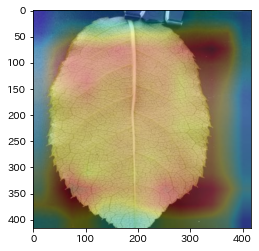

In [ ]:
device = torch.device('cpu')
gradcam_model = gradcam_model.to(device)
#画像を直接指定してgradcamする
gradcam(gradcam_model, '/content/test/mite-free/IMG_20220330_101129_jpg.rf.1a33b9ba493e21ee17ef6682a2adca28.jpg')